In [1]:
%matplotlib notebook
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import errno

###############################  To get reproducible results  ########################################
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  # Do other imports now...


# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)


# 5. Configure a new global `tensorflow` session
from keras import backend as K

"""
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
"""

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras


#######################################################################################################



import pandas as pd

from keras.layers import Layer
from keras.layers import Dense, Dropout, Input, Activation
from keras.layers import Conv2D, Flatten, Lambda, MaxPooling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.datasets import mnist as in_dist_dataset
from keras.datasets import fashion_mnist as out_dist_dataset
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.models import load_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import argparse
import os

import tensorflow as tf
from keras.optimizers import RMSprop, SGD, Adam, Adadelta

from keras.constraints import Constraint, NonNeg
from keras.constraints import Constraint

from keras.callbacks import EarlyStopping
from keras.initializers import Ones, Constant

from keras import regularizers

from sympy import Matrix


from sklearn.mixture import GaussianMixture
import pickle

import h5py

from sklearn import metrics

Using TensorFlow backend.


In [2]:
in_dist = "mnist"
out_dist = "fmnist"
number_of_classes = 11
in_class_min = 0
in_class_max = 9
latent_dim = 8

In [3]:
# n = number of points per class - 2 class data
def generate_nd_sphere_data(r, dims, n):
    # number of points
    X = np.zeros((n, dims))
    for i in range(dims):
        X[:, i] = np.random.normal(0, 1, n)

    D = np.sqrt(np.sum(np.square(X), axis=-1))

    X = X*1.0*r[:, np.newaxis]/D[:, None]
    y = np.ones((n, 1)) * (number_of_classes-1)

    #Y = np_utils.to_categorical(Y, 3)


    return X, y

In [4]:
def generate_nd_hyperellipsoid_data(m, Cov, r, dims, n):
    # generate for randorm radii between r and r+0.5r
    rs = np.random.uniform(r, r+0.5*r, n)
    X, y = generate_nd_sphere_data(rs, dims, n)
    #print(np.max(X))
    #Cov_inv = np.linalg.pinv(Cov)
    Cov_inv = Cov
    C = np.zeros_like(Cov)
    
    for i in range(C.shape[0]):
        for j in range(i+1):
            s1 = 0
            for k in range(j):
                s1 += C[i,j]*C[j,k]
            s2 = 0
            for k in  range(j):
                s2 += C[j,k]*C[j,k]
            C[i,j] = (Cov[i,j] - s1)/np.sqrt(np.abs(Cov[j,j] - s2))
    
    for i in range(X.shape[0]):
        X[i, :] = np.dot(C, X[i, :]) + m
    
    return X, y

In [5]:
def auroc(in_dist, out_dist):
    #calculate the AUROC

    Y1 = out_dist
    X1 = in_dist
    end = np.max([np.max(X1), np.max(Y1)])
    start = np.min([np.min(X1),np.min(Y1)])
    gap = (end- start)/200000

    aurocBase = 0.0
    fprTemp = 1.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        fpr = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        #f1.write("{}\n".format(tpr))
        #f2.write("{}\n".format(fpr))
        aurocBase += (-fpr+fprTemp)*tpr
        fprTemp = fpr

    return aurocBase

In [6]:
def sklearn_auroc(p_in, p_out):
    y = list(np.ones(p_in.shape[0]))
    y.extend(np.zeros(p_out.shape[0]))
    pred = list(np.concatenate((p_in, p_out),axis=0))

    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
    
    # for fpr95
    idx_95 = (np.abs(tpr - 0.95)).argmin()
    idx_80 = (np.abs(tpr - 0.80)).argmin()
    return metrics.auc(fpr, tpr), fpr[idx_95], fpr[idx_80]

In [7]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    # return z_mean + K.exp(0.5 * z_log_var) * epsilon
    return z_mean


In [8]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_"+in_dist):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, Y_test = data

    
    try:
        os.makedirs(model_name)
    except OSError as e:
        pass

    #os.makedirs(model_name, exist_ok=True)

    z_mean, _, _ = encoder.predict([x_test, Y_test],
                                   batch_size=batch_size)


    if z_mean.shape[1]==2:
        filename = os.path.join(model_name, "vae_mean.png")
        # display a 2D plot of the digit classes in the latent space
        plt.figure(figsize=(12, 10))
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=np.argmax(Y_test, axis=-1))
        plt.colorbar()
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.savefig(filename)
        plt.show()

    z = np.hstack((z_mean, Y_test))
    n=30
    digit_size = 28
    x_decoded = decoder.predict(z)
    print(x_decoded.shape)

    filename = os.path.join(model_name, "reconstructed_digits.png")

    figure = np.zeros((digit_size * n, digit_size * n))


    count = 0
    for i in range(n):
        for j in range(n):
            digit = x_decoded[count].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            count += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [9]:
class Vae:
    def __init__(self, load_weights):
        
        # MNIST dataset
        (self.x_train, self.y_train), (self.x_test, self.y_test) = in_dist_dataset.load_data()


        ind_train = np.where((self.y_train >= in_class_min) & (self.y_train <= in_class_max))[0]
        ind_test = np.where((self.y_test >= in_class_min) & (self.y_test <= in_class_max))[0]

        self.Y_train = np_utils.to_categorical(self.y_train[ind_train,], number_of_classes-1)
        self.Y_test = np_utils.to_categorical(self.y_test[ind_test], number_of_classes-1)

        image_size = self.x_train.shape[1]
        self.x_train = np.reshape(self.x_train, [-1, image_size, image_size, 1])
        self.x_test = np.reshape(self.x_test, [-1, image_size, image_size, 1])
        self.x_train = self.x_train.astype('float32') / 255
        self.x_test = self.x_test.astype('float32') / 255

        # network parameters
        input_shape = (image_size, image_size, 1)
        self.batch_size = 128
        kernel_size = 3
        filters = 16
        self.latent_dim = latent_dim
        epochs = 100

        # VAE model = encoder + decoder
        # build encoder model
        inputs = Input(shape=input_shape, name='encoder_input')
        cond_inputs = Input(shape=(number_of_classes-1, ))
        x = inputs
        for i in range(2):
            filters *= 2
            x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

        # shape info needed to build decoder model
        shape = K.int_shape(x)
    
        # generate latent vector Q(z|X)
        x = Flatten()(x)
        x = concatenate([x, cond_inputs])
        x = Dense(16, activation='relu')(x)
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        # instantiate encoder model
        self.encoder = Model([inputs, cond_inputs], [z_mean, z_log_var, z], name='encoder')
        self.encoder.summary()
        #plot_model(self.encoder, to_file='vae_encoder.png', show_shapes=True)

        z_cond = concatenate([z, cond_inputs])

        # build decoder model
        latent_inputs = Input(shape=(self.latent_dim+(number_of_classes-1),), name='z_sampling')
        
        x = Dense(16, activation='relu')(latent_inputs)
        x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        filters_new = filters
        for i in range(2):
            x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
            filters //= 2

        outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        self.decoder.summary()
        #plot_model(self.decoder, to_file='vae_decoder.png', show_shapes=True)

        # decoder_new
        latent_inputs_new = Input(shape=(self.latent_dim+(number_of_classes-1),), name='z_sampling')
        x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs_new)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        for i in range(2):
            x = Conv2DTranspose(filters=filters_new,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
            filters_new //= 2

        x = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

        outputs_new = Flatten()(x)

        # instantiate decoder model
        self.decoder_new = Model(latent_inputs_new, outputs_new, name='decoder')
        self.decoder_new.summary()

        # instantiate VAE model
        outputs = self.decoder(z_cond)
        vae = Model([inputs, cond_inputs], outputs, name='vae')

        
        models = (self.encoder, self.decoder)

        # VAE loss = mse_loss or xent_loss + kl_loss
        #reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))

        reconstruction_loss *= image_size * image_size
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae.add_loss(vae_loss)
        #vae.add_loss(reconstruction_loss)
        vae.compile(optimizer='rmsprop')
        vae.summary()
        #plot_model(vae, to_file='vae.png', show_shapes=True)

        ind_train = np.where((self.y_train >= in_class_min) & (self.y_train <= in_class_max))[0]
        ind_test = np.where((self.y_test >= in_class_min) & (self.y_test <= in_class_max))[0]

        data = (self.x_test[ind_test,], self.Y_test)
        print("x_test shape is: ", self.x_test[ind_test,].shape)
        if(load_weights):
            print("loading weights for vae")
            vae.load_weights('vae_'+in_dist+'.h5')
            print("finished loading weights f")
            # train the autoencoder
        else:
            vae.fit([self.x_train[ind_train,], self.Y_train],
                epochs=epochs,
                batch_size=self.batch_size,
                validation_data=([self.x_test[ind_test,], self.Y_test], None),
                callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
            vae.save_weights('vae_'+in_dist+'.h5')
        self.set_decoder_new_weights()
        plot_results(models, data, batch_size=self.batch_size, model_name="vae")

    def set_decoder_new_weights(self):
        print("setting new decoder weights")
        for i, layer in enumerate(self.decoder.layers):
            print("i is: ", i)
            self.decoder_new.layers[i].set_weights(layer.get_weights())

W0922 15:57:53.547172 140484938495744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 15:57:53.552768 140484938495744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 15:57:53.556927 140484938495744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 15:57:53.672149 140484938495744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4409: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

W0922 15:57:54.076163 140484938495744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.

W0922 15:57:54.082298 140484938495744 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0922 15:57:54.104186 140484938495744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 18)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              59584     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0   

<IPython.core.display.Javascript object>


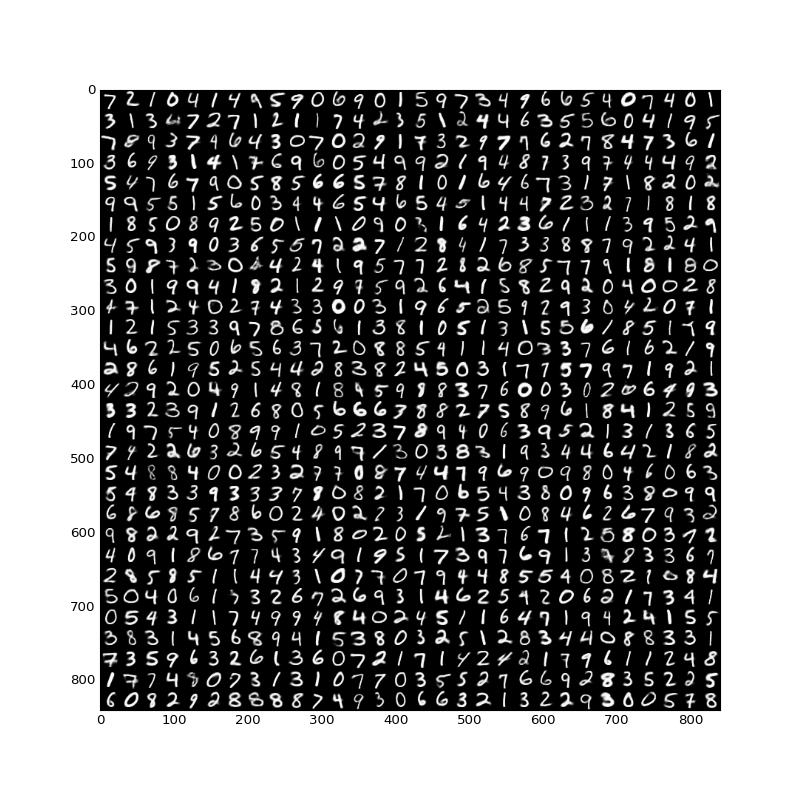

In [10]:
vae = Vae(load_weights=True)

In [11]:
def get_jacobian_functions(model, classes=None):

        if model==None:
            print("The model is none.")
            return None
    
        if classes==None:
            classes=range(784)
        #--------------------------------    
        gradients = {}
        for c in classes:
            grads = K.gradients(model.output[:,c], model.layers[0].input)[0]
            gradients[c]= K.function([model.layers[0].input], [grads])              
        #--------------------------------
        return gradients

# output is np.array of shape (inputs.shape[0], input_dim, latent_dim)
def get_jacobian(inputs, encoder, decoder):
        J_fn = get_jacobian_functions(decoder)

        z_mean, _, _ = encoder.predict(inputs)
        J = np.empty((z_mean.shape[0], 784, z_mean.shape[1]))

        z = np.hstack((z_mean, inputs[1]))

        # do it batch_wise
        n = z_mean.shape[0]
        batch_size = min(n, 10000)
        start = 0
        end = batch_size
        while(start<n):
            for i in range(len(J_fn)):
                J[start:end, i, :] = J_fn[i]([z[start:end]])[0][:, 0:z_mean.shape[1]]
                print(i)
            start = start+batch_size
            end = min(end+batch_size, n)

        return J

    
ind_train = np.where((vae.y_train >= in_class_min) & (vae.y_train <= in_class_max))[0]
ind_test = np.where((vae.y_test >= in_class_min) & (vae.y_test <= in_class_max))[0]

Y_train = np_utils.to_categorical(vae.y_train[ind_train, ])
Y_test = np_utils.to_categorical(vae.y_test[ind_test, ])

print("Calculating Jacobians")
J_train = get_jacobian([vae.x_train[ind_train,], Y_train], vae.encoder, vae.decoder_new)
print("J_train done!")
J_test = get_jacobian([vae.x_test[ind_test,], Y_test], vae.encoder, vae.decoder_new)
print("J_test done!")
np.save('J_train_'+in_dist+'.npy', J_train)
np.save('J_test_'+in_dist+'.npy', J_test)

print("Jacobians calculated")

Calculating Jacobians
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36

339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588


In [ ]:
J_fn=get_jacobian_functions(vae.decoder_new)
print(len(J_fn))

In [ ]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [ ]:
print(sess)

In [ ]:
#vae.decoder_new.input.sha

In [11]:
# Classifier

# Build a classifier with outlier samples only from the boundary.
import keras

class Classifier:

    # 3 Class classifier - class 2 represents outliers and class 0,1 represent inliers.
    # Class 0 sampled from a circle centered at (x, y) = (-2, 0) with radius 0.5
    # Class 1 sampled from a circle centered at (x, y) = (+2, 0) with radius 0.5
    # Class 2 sampled from rectagle with origin (x, y) = (-3, -1) with h=2, w=6 excluding regions covered by inliers.

    # Generate n points uniformly within a circle of radius r, centered at (x, y)
    # return as a numpy array n x 2 of dtype = float32
    def __init__(self, vae, is_load_J=False, is_load_test_ood=False):
        self.number_of_classes = number_of_classes
        self.input_shape = (28, 28, 1)
        self.input_dim = 28*28
        self.epochs = 200
        self.batch_size = 128
        self.init_lr = 0.01
        #self.decay = 0.001
        self.class_weight = self.set_class_weight(ood_class_weight=0.1)
        #self.class_weight_decay = 0.001
        self.model = self.get_model()

        self.nullspaces = h5py.File('/data/sverneka/full_mnist_0_9_cond_latent_dim_8/nullspaces_'+in_dist+'.hdf5', 'r')

        self.maha_info = self.get_mahalanobis_info(vae.encoder)

        self.X_train, self.Y_train, self.X_test, self.Y_test, self.X_test_in_dist, self.Y_test_in_dist, self.X_test_ood_in_dist, self.Y_test_ood_in_dist, self.X_test_ood_out_dist, self.Y_test_ood_out_dist, self.X_test_notMNIST, self.X_test_eMNIST = self.get_data(vae, is_load_J, is_load_test_ood)

        self.x_ood_sphere, self.Y_ood_sphere = generate_nd_sphere_data(np.ones(2000)*self.get_sphere_radius(vae.x_train)+2, self.input_dim, 2000)
        self.x_ood_sphere = np.reshape(self.x_ood_sphere, [-1, self.input_shape[0], self.input_shape[1], self.input_shape[2]])
        self.Y_ood_sphere = np_utils.to_categorical(self.Y_ood_sphere, self.number_of_classes)
        self.inds_temp = None

    def set_class_weight(self, ood_class_weight=0.5):
        class_weight = {}
        for i in range(self.number_of_classes-1):
            class_weight[i] = 1.0
        class_weight[self.number_of_classes-1] = ood_class_weight
        return class_weight


    def get_sphere_radius(self, x):
        return np.max(np.sqrt(np.sum(np.square(x), axis=(1, 2, 3))))


    def calculate_auroc(self):

        inds_out = np.where(self.Y_test[:, self.number_of_classes-1] == 1)[0]
        inds_in = np.array(range(self.Y_test.shape[0]))
        inds_in = np.delete(inds_in, inds_out, axis=0)


    
        p_out = 1.0 - self.model.predict(self.X_test[inds_out])[:,-1]
        p_in = 1.0 - self.model.predict(self.X_test[inds_in])[:,-1]
        #p_ood_in_dist = 1 - self.model.predict(self.X_test_ood_in_dist)[:,-1]
        p_ood_out_dist = 1 - self.model.predict(self.X_test_ood_out_dist)[:,-1]
        p_ood_sphere = 1 - self.model.predict_proba(self.x_ood_sphere)[:,-1]
        p_ood_notMNIST = 1 - self.model.predict_proba(self.X_test_notMNIST)[:,-1]
        p_ood_eMNIST = 1 - self.model.predict_proba(self.X_test_eMNIST)[:,-1]


        print("With prediction prob of n+1^th class")
        print("SKLERAN AUROC and fpr_95 for generated_ood is: ", sklearn_auroc(p_in, p_out))
        #print("SKLEARN AUROC and fpr_95 for %s_ood is: " % in_dist, sklearn_auroc(p_in, p_ood_in_dist))
        print("SKLEARN AUROC and fpr_95 for %s_ood is: " % out_dist, sklearn_auroc(p_in, p_ood_out_dist))
        print("SKLEARN AUROC and fpr_95 for sphere_ood is: ", sklearn_auroc(p_in, p_ood_sphere))
        print("SKLEARN AUROC and fpr_95 for notMNIST is: ", sklearn_auroc(p_in, p_ood_notMNIST))
        print("SKLEARN AUROC and fpr_95 for eMnist is: ", sklearn_auroc(p_in, p_ood_eMNIST))

        p_out = np.max(self.model.predict(self.X_test[inds_out])[:,0:-1], axis=-1)
        p_in = np.max(self.model.predict(self.X_test[inds_in])[:,0:-1], axis=-1)
        #p_ood_in_dist = np.max(self.model.predict(self.X_test_ood_in_dist)[:,0:-1], axis=-1)
        p_ood_out_dist = np.max(self.model.predict(self.X_test_ood_out_dist)[:,0:-1], axis=-1)
        p_ood_sphere = np.max(self.model.predict(self.x_ood_sphere)[:,0:-1], axis=-1)
        p_ood_notMNIST = np.max(self.model.predict(self.X_test_notMNIST)[:,0:-1], axis=-1)
        p_ood_eMNIST = np.max(self.model.predict(self.X_test_eMNIST)[:,0:-1], axis=-1)


        """
        print("AUROC for generated_ood is: ", auroc(p_in, p_out))
        #print("AUROC for %s_ood is: " % in_dist, auroc(p_in, p_ood_in_dist))
        print("AUROC for %s_ood is: " % out_dist, auroc(p_in, p_ood_out_dist))
        print("AUROC for sphere_ood is: ", auroc(p_in, p_ood_sphere))
        print("AUROC for notMNIST is: ", auroc(p_in, p_ood_notMNIST))
        print("AUROC for eMnist is: ", auroc(p_in, p_ood_eMNIST))
        """
        print("With maximum prediction probability of n classes")
        print("SKLERAN AUROC and fpr_95 for generated_ood is: ", sklearn_auroc(p_in, p_out))
        #print("SKLEARN AUROC and fpr_95 for %s_ood is: " % in_dist, sklearn_auroc(p_in, p_ood_in_dist))
        print("SKLEARN AUROC and fpr_95 for %s_ood is: " % out_dist, sklearn_auroc(p_in, p_ood_out_dist))
        print("SKLEARN AUROC and fpr_95 for sphere_ood is: ", sklearn_auroc(p_in, p_ood_sphere))
        print("SKLEARN AUROC and fpr_95 for notMNIST is: ", sklearn_auroc(p_in, p_ood_notMNIST))
        print("SKLEARN AUROC and fpr_95 for eMnist is: ", sklearn_auroc(p_in, p_ood_eMNIST))


        #print("AUROC for sphere_ood is: ", auroc(p_in, p_ood_sphere))

    """
    def get_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape, name='input'))
        model.add(Flatten())
        model.add(Dense(500, input_shape=(self.input_dim,), kernel_regularizer=keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(Dense(500, kernel_regularizer=keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(Dense(self.number_of_classes, kernel_regularizer=keras.regularizers.l2(0.01)))
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation(tf.nn.softmax))
        model.compile(loss='binary_crossentropy', optimizer=Adam(self.init_lr), metrics=['accuracy'])
        return model
    """


    def get_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=self.input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.number_of_classes))
        model.add(Activation(tf.nn.softmax))
        model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(self.init_lr),
              metrics=['accuracy'])
        return model



    def get_model_old(self):
        inputs = Input(shape=self.input_shape, name='input')
        x = Flatten()(inputs)
        x = Dense(500, input_shape=(self.input_dim,), kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = Activation('relu')(x)
        x = Dense(500, kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = Activation('relu')(x)
        x = Dense(self.number_of_classes, kernel_regularizer=keras.regularizers.l2(0.01))(x)
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        y = Activation(tf.nn.softmax)(x)
        model = Model(inputs, y)
        model.compile(loss='categorical_crossentropy', optimizer=Adadelta(self.init_lr), metrics=['accuracy'])
        return model


    
    def train_old(self, vae, is_load):

        if is_load:
            self.model.load_weights('classifier_10d_'+in_dist+'.h5')
        else:
            # fit the model
            for i in range(self.epochs):
                start = 0
                end = min(start+self.batch_size, self.X_train.shape[0])

                X_ood_1, y_ood_1 = self.generate_ood_points(self.X_train, dtype='n_train')
                Y_ood_1 = np_utils.to_categorical(y_ood_1, self.number_of_classes)

                X_ood_2, y_ood_2 = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, self.Y_train)
                Y_ood_2 = np_utils.to_categorical(y_ood_2, self.number_of_classes)

                while(start < self.X_train.shape[0]):
                    inds = np.random.choice(range(self.X_train.shape[0]), int((end-start)/2))
                    #inds = np.random.choice(range(self.X_train.shape[0]), int((end-start)/self.number_of_classes))
                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[start:end], None, None, self.N_train[start:end])
                    #Y_ood_batch = np_utils.to_categorical(y_ood_batch, self.number_of_classes)
                    
                    X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[inds], inds, dtype='n_train')
                    X_ood_batch = np.expand_dims(X_ood_batch, axis=-1)
                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[inds], vae.encoder, vae.decoder, self.N_train[inds])
                    
                    Y_ood_batch = np_utils.to_categorical(y_ood_batch, self.number_of_classes)

                    X_ood_batch_2, y_ood_batch_2  = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, int((end-start)/2))
                    #X_ood_batch_2, y_ood_batch_2  = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, int((end-start)/self.number_of_classes))
                    Y_ood_batch_2 = np_utils.to_categorical(y_ood_batch, self.number_of_classes)
                    
                    X_train_batch = np.vstack((self.X_train[start:end], X_ood_batch, X_ood_batch_2))
                    Y_train_batch = np.vstack((self.Y_train[start:end], Y_ood_batch, Y_ood_batch_2))

                    self.model.train_on_batch(X_train_batch, Y_train_batch, class_weight=self.class_weight)

                    start = end
                    end = start + self.batch_size
                print('After epoch ', i)
                print('Train results: ')
                print(self.model.evaluate(self.X_train, self.Y_train))
                print('Test results: ')
                print(self.model.evaluate(self.X_test, self.Y_test))
                print('Indistribution Test results: ')
                print(self.model.evaluate(self.X_test_in_dist, self.Y_test_in_dist))
                #print('Evaluate ood results for %s: ' % in_dist)
                #self.evaluate_ood((self.X_test_ood_in_dist, self.Y_test_ood_in_dist))
                print('Evaluate ood results for %s: ' % out_dist)
                self.evaluate_ood((self.X_test_ood_out_dist, self.Y_test_ood_out_dist))
                print('Evaluate ood results for sphere ood: ')
                self.evaluate_ood((self.x_ood_sphere, self.Y_ood_sphere))
                self.calculate_auroc()
                print()
                lr = K.eval(self.model.optimizer.lr)
                lr *= (1.0 / (1.0 + self.decay * (i+1)))
                K.set_value(self.model.optimizer.lr, lr)
                print("learning rate is: ", lr)
                self.class_weight[self.number_of_classes-1] = self.class_weight[self.number_of_classes-1] * (1.0 / (1.0 + self.class_weight_decay * (i+1)))
                print("OOD class weight: ", self.class_weight[self.number_of_classes-1])

            self.model.save_weights('classifier_10d_'+in_dist+'.h5')

    def train(self, vae, is_load):

        X_ood_1 = None
        Y_ood_1 = None
        if is_load:
            self.model.load_weights('classifier_10d_'+in_dist+'.h5')
        else:
            # fit the model
            for i in range(self.epochs):
                start = 0
                end = min(start+self.batch_size, self.X_train.shape[0])

                # Generate OOD points every 5th epoch
                
                if i%5==0:
                    print("Generate OOD points every 5 epoch")
                    print("Generating ood points for epoch: ", i)
                    X_ood_1, y_ood_1 = self.generate_ood_points_new(self.X_train, dtype='n_train')
                    #X_ood_1 = np.expand_dims(X_ood_1, axis=-1)
                    Y_ood_1 = np_utils.to_categorical(y_ood_1, self.number_of_classes)
                    print("Finished generating ood points for epoch: ", i)

                print("Generating mahalanobis points for epoch: ", i)
                X_ood_2, y_ood_2 = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, self.Y_train)
                #X_ood_2 = np.expand_dims(X_ood_2, axis=-1)
                Y_ood_2 = np_utils.to_categorical(y_ood_2, self.number_of_classes)
                print("Finished generating mahalanobis points for epoch: ", i)

                while(start < self.X_train.shape[0]):
                    inds = np.random.choice(range(self.X_train.shape[0]), int((end-start)/2))
                    #inds.sort()
                    #inds = np.random.choice(range(self.X_train.shape[0]), int((end-start)/self.number_of_classes))
                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[start:end], None, None, self.N_train[start:end])
                    #Y_ood_batch = np_utils.to_categorical(y_ood_batch, self.number_of_classes)

                    #X_ood_batch_1, y_ood_batch_1 = self.generate_ood_points(self.X_train[inds], inds, dtype='n_train')
                    #X_ood_batch_1 = np.expand_dims(X_ood_batch_1, axis=-1)
                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[inds], vae.encoder, vae.decoder, self.N_train[inds])
                    
                    X_ood_batch_1, Y_ood_batch_1  = X_ood_1[inds,], Y_ood_1[inds, ]
                    #Y_ood_batch_1 = np_utils.to_categorical(y_ood_batch_1, self.number_of_classes)

                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[inds], vae.encoder, vae.decoder, self.N_train[inds])

                    X_ood_batch_2, Y_ood_batch_2  = X_ood_2[inds,], Y_ood_2[inds, ]
                    #X_ood_batch_2, y_ood_batch_2  = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, int((end-start)/self.number_of_classes))

                    #print(X_ood_batch_1.shape)
                    #print(X_ood_batch_2.shape)
                    X_train_batch = np.vstack((self.X_train[start:end], X_ood_batch_1, X_ood_batch_2))
                    Y_train_batch = np.vstack((self.Y_train[start:end], Y_ood_batch_1, Y_ood_batch_2))

                    self.model.train_on_batch(X_train_batch, Y_train_batch, class_weight=self.class_weight)

                    start = end
                    end = start + self.batch_size
                print('After epoch ', i)
                print('Train results: ')
                print(self.model.evaluate(self.X_train, self.Y_train))
                print('Test results: ')
                print(self.model.evaluate(self.X_test, self.Y_test))
                print('Indistribution Test results: ')
                print(self.model.evaluate(self.X_test_in_dist, self.Y_test_in_dist))
                #print('Evaluate ood results for %s: ' % in_dist)
                #self.evaluate_ood((self.X_test_ood_in_dist, self.Y_test_ood_in_dist))
                print('Evaluate ood results for %s: ' % out_dist)
                self.evaluate_ood((self.X_test_ood_out_dist, self.Y_test_ood_out_dist))
                print('Evaluate ood results for sphere ood: ')
                self.evaluate_ood((self.x_ood_sphere, self.Y_ood_sphere))
                self.calculate_auroc()
                print()
                lr = K.eval(self.model.optimizer.lr)
                #lr *= (1.0 / (1.0 + self.decay * (i+1)))
                K.set_value(self.model.optimizer.lr, lr)
                print("learning rate is: ", lr)
                #self.class_weight[self.number_of_classes-1] = self.class_weight[self.number_of_classes-1] * (1.0 / (1.0 + self.class_weight_decay * (i+1)))
                print("OOD class weight: ", self.class_weight[self.number_of_classes-1])

            self.model.save_weights('classifier_10d_'+in_dist+'.h5')


    def evaluate_ood(self, data):
        x, y = data
        print(self.model.evaluate(x, y))


    def get_mahalanobis_dist(self, m, cov_inv, z):
        return np.sqrt((z-m).dot(cov_inv).dot((z-m).T))


    def get_hyperellipsoid_info(self, vae_encoder, label=0):
                    
        ind_train = np.where((vae.y_train == label))[0]
        ind_test = np.where((vae.y_test == label))[0]

        Y = np.zeros((ind_train.shape[0], self.number_of_classes-1))
        Y[:, label] = 1

        z, _, _ = vae_encoder.predict([vae.x_train[ind_train,], Y])

        m = np.mean(z, axis=0)
        cov = np.cov(z.T)
        cov_inv = np.linalg.pinv(cov)

        maha_dist = []
        for i in range(z.shape[0]):
            maha_dist.append(self.get_mahalanobis_dist(m, cov_inv, z[i]))
        
        maha_dist.sort()
        
        d_95 = maha_dist[int(0.95*len(maha_dist))]

        return [m, cov, d_95]

    def get_mahalanobis_info(self, vae_encoder):
        maha_info = []
        for i in range(self.number_of_classes-1):
            maha_info.append(self.get_hyperellipsoid_info(vae_encoder, i))
        
        return maha_info
            

    def generate_ood_points(self, data, inds, dtype='n_train'):
        epsilon = np.random.uniform(0.1, 28.0, data.shape[0])
        rand_nums = np.random.choice([-1, 1], data.shape[0])
        ood_data = []

        for i in range(data.shape[0]):
            #print("Calculating nullspace for: ", i)
            N = self.nullspaces[dtype][inds[i]]
            #print("Finished calculating nullspace for: ", i)
            # for linear combination of vectors
            epsilon_n = np.random.uniform(-1, 1, (1, N.shape[0]))
            vec = np.sum(epsilon_n[0]*N.T, axis=-1)
            # normalize the vector
            vec = vec*1.0/np.sqrt(np.sum(np.square(vec)))
            perturbed_data = data[i] + (rand_nums[i] * epsilon[i] * vec).reshape(data[i].shape[0], data[i].shape[1], data[i].shape[2])
            
            # threshold values at 1.0
            perturbed_data[(perturbed_data > 1.0)] = 1.0
            perturbed_data[(perturbed_data < 0.0)] = 0.0

            ood_data.append(perturbed_data)
            #ood_data.append(data[i] + rand_nums[i] * epsilon[i] * N[i, rand_vector_inds[i]])

        return np.squeeze(np.array(ood_data)), (self.number_of_classes-1) * np.ones((data.shape[0], 1))


    def generate_ood_points_new(self, data, dtype='n_train'):
        epsilon = np.random.uniform(0.1, 28.0, data.shape[0])
        rand_nums = np.random.choice([-1, 1], data.shape[0])

        ood_data = np.empty_like(data)
        for i in range(data.shape[0]):
            #print("Calculating nullspace for: ", i)
            N = self.nullspaces[dtype][i]
            #print("Finished calculating nullspace for: ", i)
            # for linear combination of vectors
            epsilon_n = np.random.uniform(-1, 1, (1, N.shape[0]))
            vec = np.sum(epsilon_n[0]*N.T, axis=-1)
            # normalize the vector
            vec = vec*1.0/np.sqrt(np.sum(np.square(vec)))
            perturbed_data = data[i] + (rand_nums[i] * epsilon[i] * vec).reshape(data[i].shape[0], data[i].shape[1], data[i].shape[2])
            
            # threshold values at 1.0
            perturbed_data[(perturbed_data > 1.0)] = 1.0
            perturbed_data[(perturbed_data < 0.0)] = 0.0

            ood_data[i, ] = perturbed_data
            if(i%10000==0):
                print(i)
            #ood_data.append(perturbed_data)

        return ood_data, (self.number_of_classes-1) * np.ones((data.shape[0], 1))

    """
    def generate_ood_points_new(self, data, inds, dtype='n_train'):
        epsilon = np.random.uniform(0.1, 28.0, data.shape[0])
        rand_nums = np.random.choice([-1, 1], data.shape[0])

        self.inds_temp = inds
        print(inds.shape)
        N = self.nullspaces[dtype][list(inds)]
        epsilon_n = np.random.uniform(-1, 1, (N.shape[0], N.shape[1]))

        vecs = np.sum(np.expand_dims(epsilon_n, 1)*np.transpose(N, (0, 2, 1)), axis=-1)
        vecs = vecs*1.0/np.sqrt(np.sum(np.square(vecs), axis=-1))[:, None]

        perturbed_data = data + (rand_nums[:, None] * epsilon[:, None] * vecs).reshape((data.shape[0], data.shape[1], data.shape[2], data.shape[3]))
        
        perturbed_data[(perturbed_data > 1.0)] = 1.0

        return perturbed_data, (self.number_of_classes-1) * np.ones((data.shape[0], 1))
    """

    def generate_mahalanobis_ood_old(self, decoder, dims, n):
        
        Z = []
        Y = []
        labels = np.zeros((n, self.number_of_classes-1))
        for i in range(n):
            k = np.random.randint(0, self.number_of_classes-1, 1)[0]
            z, y = generate_nd_hyperellipsoid_data(self.maha_info[k][0], 
                                                   self.maha_info[k][1], self.maha_info[k][2], dims, 1)
            labels[i, k] = 1
            Z.append(z)
            Y.append(y)
        
        Z = np.squeeze(np.array(Z), axis=1)
        Y = np.squeeze(np.array(Y), axis=1)

        #print("z and labels dimensions are: ", Z.shape, labels.shape)
        x = decoder.predict(np.hstack((Z, labels)))
        return x, Y

    def generate_mahalanobis_ood(self, decoder, dims, Y):
        Z = np.empty((Y.shape[0], dims))
        for i in range(Y.shape[1]-1):
            inds = np.where((Y[:, i] == 1))[0]
            z, _ = generate_nd_hyperellipsoid_data(self.maha_info[i][0], 
                                                   self.maha_info[i][1], self.maha_info[i][2], dims, inds.shape[0])
            Z[inds, :] = z
        print("shape of z is: ", Z.shape)
        X = decoder.predict(np.hstack((Z, Y[:,0:-1])))
        y = np.ones((Y.shape[0])) * (self.number_of_classes-1)
        return X, y


    def get_data(self, vae, is_load_J, is_load_test_ood=False):

        # take digits 0 and 1 as inliers and rest as outliers
        #N_train = None
        #N_test = None
        ind_train = np.where((vae.y_train >= in_class_min) & (vae.y_train <= in_class_max))[0]
        ind_test = np.where((vae.y_test >= in_class_min) & (vae.y_test <= in_class_max))[0]

        """
        if is_load_J:
            print("Loading Jacobians")
            J_train = np.load('J_train_'+in_dist+'.npy')
            J_test = np.load('J_test_'+in_dist+'.npy')
        else:
            print("Calculating Jacobians")
            J_train = self.get_jacobian(vae.x_train[ind_train,], vae.encoder, vae.decoder_new)
            J_test = self.get_jacobian(vae.x_test[ind_test,], vae.encoder, vae.decoder_new) 
            np.save('J_train_'+in_dist+'.npy', J_train)
            np.save('J_test_'+in_dist+'.npy', J_test)

        print("Jacobians calculated")
        """

        x_train_ood_in_dist = np.delete(vae.x_train, ind_train, axis=0)
        y_train_ood_in_dist = np.delete(vae.y_train, ind_train, axis=0)
        y_train_ood_in_dist[:] = self.number_of_classes-1

        #x_test_ood, y_test_ood = self.generate_ood_points(vae.x_test[ind_test,], vae.encoder, vae.decoder_new, None)
        x_test_ood, y_test_ood = None, None
        if is_load_test_ood:
            x_test_ood, y_test_ood = np.load('x_test_ood.npy'), np.load('y_test_ood.npy')
        else:
            print("Generating test OOD points")
            x_test_ood, y_test_ood = self.generate_ood_points(vae.x_test[ind_test,], np.array(range(ind_test.shape[0])), dtype='n_test')
            np.save('x_test_ood.npy', x_test_ood)
            np.save('y_test_ood.npy', y_test_ood)

        x_test_ood = np.expand_dims(x_test_ood, axis=-1)

        print("x_test_ood shape is: ", x_test_ood.shape[0])

        inds = np.random.choice(range(x_test_ood.shape[0]), int(x_test_ood.shape[0]/2))
        x_test_ood_1, y_test_ood_1 = x_test_ood[inds,], y_test_ood[inds,]

        #x_test_ood_2, y_test_ood_2 = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, int(x_test_ood.shape[0]/2))
        print("Generating mahalanobis test ood")
        x_test_ood_2, y_test_ood_2 = self.generate_mahalanobis_ood_old(vae.decoder, vae.latent_dim, int(x_test_ood.shape[0]/2))
        print("Finished generating mahalanobis test ood")
        
        x_test_ood_in_dist = np.delete(vae.x_test, ind_test, axis=0)
        y_test_ood_in_dist = np.delete(vae.y_test, ind_test, axis=0)
        y_test_ood_in_dist[:] = self.number_of_classes-1

        # For fmnist as ood
        (_, _),(x_test_ood_out_dist, y_test_ood_out_dist) = out_dist_dataset.load_data()
        image_size = x_test_ood_out_dist.shape[1]
        x_test_ood_out_dist = np.reshape(x_test_ood_out_dist, [-1, image_size, image_size, 1])

        x_test_ood_out_dist = x_test_ood_out_dist.astype('float32')/255.

        y_test_ood_out_dist = np.array(y_test_ood_out_dist)
        y_test_ood_out_dist[:] = self.number_of_classes-1
        
        X_train = vae.x_train[ind_train,]
        #X_test = np.vstack((vae_7d.x_test[ind_test,], x_test_ood, x_test_ood_fmnist))
        X_test = np.vstack((vae.x_test[ind_test,], x_test_ood_1, x_test_ood_2))

        X_test_in_dist = vae.x_test[ind_test, ]
        Y_test_in_dist = vae.y_test[ind_test, ]

        Y_train = np.expand_dims(vae.y_train[ind_train,], axis=1)
        #Y_test = np.vstack((np.expand_dims(vae_7d.y_test[ind_test,], axis=1), y_test_ood, np.expand_dims(y_test_ood_mnist, axis=1)))
        
        print("sizes are ", np.expand_dims(vae.y_test[ind_test,], axis=1).shape, y_test_ood_1.shape, y_test_ood_2.shape, )
        Y_test = np.vstack((np.expand_dims(vae.y_test[ind_test,], axis=1), y_test_ood_1, y_test_ood_2))

        Y_train = np_utils.to_categorical(Y_train, self.number_of_classes)
        Y_test = np_utils.to_categorical(Y_test, self.number_of_classes)
        Y_test_in_dist = np_utils.to_categorical(Y_test_in_dist, self.number_of_classes)

        Y_test_ood_in_dist = np_utils.to_categorical(y_test_ood_in_dist, self.number_of_classes)
        Y_test_ood_out_dist = np_utils.to_categorical(y_test_ood_out_dist, self.number_of_classes)

        # randomly shuffle data
        # ind = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        # X_train = X_train[ind]
        # Y_train = Y_train[ind]


        print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

        x_test_notMNIST = np.load('/data/sverneka/dataset/notMNIST.npy').astype('float32')/255.

        # EMNIST LETTERS TEST
        x_test_eMNIST = np.array(pd.read_csv("/data/sverneka/dataset/emnist-letters-test.csv", index_col=None, header=None))[:, 1:].astype('float32')/255.0
        x_test_eMNIST = x_test_eMNIST.reshape(x_test_eMNIST.shape[0], 28, 28, 1)

        # return X_train, Y_train, X_test, Y_test, X_test_fmnist, Y_test_fmnist, x_test_ood_fmnist, Y_test_ood_fmnist, J_train
        return X_train, Y_train, X_test, Y_test, X_test_in_dist, Y_test_in_dist, x_test_ood_in_dist, Y_test_ood_in_dist, x_test_ood_out_dist, Y_test_ood_out_dist, x_test_notMNIST, x_test_eMNIST



In [12]:
# Saved the model here

# With lr=0.1 and class_weight=0.1
classifier = Classifier(vae, is_load_J=True, is_load_test_ood=True)

classifier.train(vae, is_load=True)

W0922 15:58:34.147689 140484938495744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0922 15:58:34.160650 140484938495744 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


x_test_ood shape is:  10000
Generating mahalanobis test ood
Finished generating mahalanobis test ood
sizes are  (10000, 1) (5000, 1) (5000, 1)
(60000, 28, 28, 1) (60000, 11) (20000, 28, 28, 1) (20000, 11)


In [13]:
# Saved the model here

# With lr=0.1 and class_weight=0.1
classifier = Classifier(vae, is_load_J=True, is_load_test_ood=True)
K.set_value(classifier.model.optimizer.lr, 0.05)
classifier.class_weight = classifier.set_class_weight(0.1)
lr = K.eval(classifier.model.optimizer.lr)
print("learning rate is: ", lr)
print("OOD class weight: ", classifier.class_weight[classifier.number_of_classes-1])

classifier.train(vae, is_load=False)

x_test_ood shape is:  10000
Generating mahalanobis test ood
Finished generating mahalanobis test ood
sizes are  (10000, 1) (5000, 1) (5000, 1)
(60000, 28, 28, 1) (60000, 11) (20000, 28, 28, 1) (20000, 11)
learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  0
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  0
Generating mahalanobis points for epoch:  0
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  0
After epoch  0
Train results: 
60000/60000 [==============================] - 4s 72us/step
[0.35618051031430564, 0.8970666666666667]
Test results: 
20000/20000 [==============================] - 2s 76us/step
[0.9418370589494706, 0.71085]
Indistribution Test results: 
10000/10000 [==============================] - 1s 69us/step
[0.3341954216003418, 0.9044]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 71us/step
[0.4174195993185043, 0.834

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.942430985, 0.1913, 0.0969)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99449389, 0.0368, 0.0033)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999990119632557, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9412790641891893, 0.2389864864864865, 0.09074324324324325)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  5
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  5
Generating mahalanobis points for epoch:  5
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  5
After epoch  5
Train results: 
60000/60000 [==============================] - 5s 76us/step
[0.1622000039100647, 0.95375]
Test results: 
20000/20000 [==============================] - 2s 83us/step
[0.4825826511953026, 0.8602]
Indistribution Te

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.97056122, 0.1184, 0.0463)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9997085600000001, 0.0014, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999968863490707, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9660743175675676, 0.16587837837837838, 0.047972972972972976)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  10
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  10
Generating mahalanobis points for epoch:  10
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  10
After epoch  10
Train results: 
60000/60000 [==============================] - 5s 78us/step
[0.09819616851272682, 0.9722833333333334]
Test results: 
20000/20000 [==============================] - 1s 75us/step
[0.3101494196562096, 0.

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.981688925, 0.0759, 0.0264)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99990452, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999959143345439, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9728179256756757, 0.13, 0.038513513513513516)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  15
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  15
Generating mahalanobis points for epoch:  15
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  15
After epoch  15
Train results: 
60000/60000 [==============================] - 5s 75us/step
[0.07242813063456366, 0.9806]
Test results: 
20000/20000 [==============================] - 2s 76us/step
[0.21658679402954875, 0.93545]
Indistribution Test results: 

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9867724550000001, 0.0507, 0.019)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99993644, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999963042085025, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9773919054054053, 0.10905405405405405, 0.030743243243243245)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  20
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  20
Generating mahalanobis points for epoch:  20
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  20
After epoch  20
Train results: 
60000/60000 [==============================] - 4s 74us/step
[0.0556619021242174, 0.9843]
Test results: 
20000/20000 [==============================] - 2s 82us/step
[0.19878439523004926, 0.94375]
Indistrib

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9898190299999999, 0.0382, 0.0157)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999220200000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999962187566759, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.980462722972973, 0.09972972972972972, 0.024864864864864864)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  25
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  25
Generating mahalanobis points for epoch:  25
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  25
After epoch  25
Train results: 
60000/60000 [==============================] - 4s 75us/step
[0.04832261799493184, 0.9863333333333333]
Test results: 
20000/20000 [==============================] - 2s 81us/step
[0.1618857983935391

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.991636585, 0.0321, 0.0125)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99991582, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999957701345866, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.981484016891892, 0.09587837837837838, 0.022702702702702703)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  30
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  30
Generating mahalanobis points for epoch:  30
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  30
After epoch  30
Train results: 
60000/60000 [==============================] - 4s 70us/step
[0.0406164104554647, 0.98845]
Test results: 
20000/20000 [==============================] - 2s 78us/step
[0.15315771789788268, 0.9569]
Indistribution T

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9918196499999999, 0.0306, 0.0123)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9998669900000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999950491348003, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9785940945945946, 0.10581081081081081, 0.027972972972972972)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  35
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  35
Generating mahalanobis points for epoch:  35
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  35
After epoch  35
Train results: 
60000/60000 [==============================] - 4s 68us/step
[0.03578248960510828, 0.9896666666666667]
Test results: 
20000/20000 [==============================] - 1s 73us/step
[0.158107483811373

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9935261000000001, 0.0252, 0.0097)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9998788900000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999948461867122, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.982043, 0.09682432432432432, 0.019932432432432434)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  40
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  40
Generating mahalanobis points for epoch:  40
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  40
After epoch  40
Train results: 
60000/60000 [==============================] - 5s 76us/step
[0.032328200239983076, 0.9909833333333333]
Test results: 
20000/20000 [==============================] - 1s 75us/step
[0.13405188844296498, 0.962

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99498192, 0.0191, 0.0077)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9998613399999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999929395428327, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9858254797297297, 0.07939189189189189, 0.012567567567567568)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  45
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  45
Generating mahalanobis points for epoch:  45
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  45
After epoch  45
Train results: 
60000/60000 [==============================] - 4s 75us/step
[0.029013044526583206, 0.9918]
Test results: 
20000/20000 [==============================] - 2s 84us/step
[0.12866545538369392, 0.96465]
Indist

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.995274835, 0.0174, 0.0067)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9998364200000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9999999500000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99999257637257, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9863007635135136, 0.07668918918918918, 0.011013513513513514)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  50
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  50
Generating mahalanobis points for epoch:  50
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  50
After epoch  50
Train results: 
60000/60000 [==============================] - 4s 70us/step
[0.026934870963031425, 0.99245]
Test results: 
20000/20000 [==============================] - 2s 76us/step
[0.11342033933146595, 

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.995424825, 0.0172, 0.0063)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9998167900000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9999998, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999914014099551, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.986086385135135, 0.08033783783783784, 0.010743243243243243)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  55
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  55
Generating mahalanobis points for epoch:  55
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  55
After epoch  55
Train results: 
60000/60000 [==============================] - 4s 73us/step
[0.0248532734666951, 0.9929166666666667]
Test results: 
20000/20000 [==============================] - 2s 76us/step
[0.10266631721238587,

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99563318, 0.0164, 0.0059)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99981705, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9999986999999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999894466994232, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9864754527027029, 0.07952702702702703, 0.009121621621621622)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  60
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  60
Generating mahalanobis points for epoch:  60
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  60
After epoch  60
Train results: 
60000/60000 [==============================] - 4s 74us/step
[0.022966031384087787, 0.99355]
Test results: 
20000/20000 [==============================] - 2s 76us/step
[0.10310403279430291, 0.9721]

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.996554305, 0.0133, 0.0046)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99979019, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9999959, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999888592181158, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9883236756756757, 0.06804054054054054, 0.0058108108108108104)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  65
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  65
Generating mahalanobis points for epoch:  65
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  65
After epoch  65
Train results: 
60000/60000 [==============================] - 5s 79us/step
[0.021509080921895414, 0.9939333333333333]
Test results: 
20000/20000 [==============================] - 2s 80us/step
[0.09275373782500124, 0.9

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99689765, 0.0127, 0.0038)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99977757, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9999709999999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999872997222816, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9893250033783784, 0.0629054054054054, 0.0033783783783783786)

learning rate is:  0.05
OOD class weight:  0.1
Generate OOD points every 5 epoch
Generating ood points for epoch:  70
0
10000
20000


KeyboardInterrupt: 

In [12]:
# With lr=0.1 and class_weight=0.1
classifier = Classifier(vae, is_load_J=True, is_load_test_ood=False)
K.set_value(classifier.model.optimizer.lr, 0.01)
classifier.class_weight = classifier.set_class_weight(0.5)
lr = K.eval(classifier.model.optimizer.lr)
print("learning rate is: ", lr)
print("OOD class weight: ", classifier.class_weight[classifier.number_of_classes-1])

classifier.train(vae, is_load=False)

W0921 06:48:15.231100 140300339136256 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0921 06:48:15.243592 140300339136256 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Generating test OOD points
x_test_ood shape is:  10000
Generating mahalanobis test ood
Finished generating mahalanobis test ood
sizes are  (10000, 1) (5000, 1) (5000, 1)
(60000, 28, 28, 1) (60000, 11) (20000, 28, 28, 1) (20000, 11)
learning rate is:  0.01
OOD class weight:  0.5
Generate OOD points every 5 epoch
Generating ood points for epoch:  0
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  0
Generating mahalanobis points for epoch:  0
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  0
After epoch  0
Train results: 
60000/60000 [==============================] - 4s 74us/step
[1.2940374741872152, 0.6651166666666667]
Test results: 
20000/20000 [==============================] - 2s 80us/step
[1.054080387878418, 0.75805]
Indistribution Test results: 
10000/10000 [==============================] - 1s 77us/step
[1.2571296937942504, 0.6887]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 73us/step
[

With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.935100385, 0.1906, 0.1163)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9951639199999999, 0.0276, 0.0037)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99998933988464, 0.00010681478316599017, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9161137398648647, 0.2783108108108108, 0.14337837837837838)

learning rate is:  0.01
OOD class weight:  0.5
Generate OOD points every 5 epoch
Generating ood points for epoch:  5
0
10000
20000
30000
40000
50000
Finished generating ood points for epoch:  5
Generating mahalanobis points for epoch:  5
shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  5
After epoch  5
Train results: 
60000/60000 [==============================] - 4s 71us/step
[0.42514759182929995, 0.8845666666666666]
Test results: 
20000/20000 [==============================] - 1s 73us/step
[0.425581

With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.977511965, 0.0857, 0.0328)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9995177099999999, 0.0011, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999788613544115, 5.3407391582995086e-05, 5.3407391582995086e-05)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9594124087837838, 0.16243243243243244, 0.06054054054054054)
With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.961393735, 0.1226, 0.068)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9985182, 0.0069, 0.001)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999961760307626, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.936753320945946, 0.22378378378378377, 0.10432432432432433)

learning rate is:  0.01
OOD class weight:  0.5
Generate OOD points every 5 epoch
Generating 

[0.2809277559906244, 0.91615]
Indistribution Test results: 
10000/10000 [==============================] - 1s 74us/step
[0.2618402115404606, 0.9299]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 72us/step
[0.01408368285279721, 0.9971]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 68us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.98486329, 0.0561, 0.0207)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99977825, 0.0004, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999850459303568, 5.3407391582995086e-05, 5.3407391582995086e-05)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.9667738547297298, 0.1320945945945946, 0.04675675675675676)
With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9729585049999999, 0.0899, 0.0458)
SKLEAR

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  19
After epoch  19
Train results: 
60000/60000 [==============================] - 4s 72us/step
[0.23713888323307036, 0.9348]
Test results: 
20000/20000 [==============================] - 2s 77us/step
[0.228931925714761, 0.9324]
Indistribution Test results: 
10000/10000 [==============================] - 1s 77us/step
[0.2247953506410122, 0.9373]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 76us/step
[0.006393939258146565, 0.999]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 71us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9890294650000001, 0.0398, 0.0149)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99989449, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999927686391796, 5.34073915

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  24
After epoch  24
Train results: 
60000/60000 [==============================] - 4s 74us/step
[0.20393909849425157, 0.9446833333333333]
Test results: 
20000/20000 [==============================] - 1s 71us/step
[0.19860981925521046, 0.94195]
Indistribution Test results: 
10000/10000 [==============================] - 1s 71us/step
[0.19519041841626167, 0.9454]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 74us/step
[0.004381676408374915, 0.9992]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 82us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9914158150000001, 0.0305, 0.0109)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99993091, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99999619739

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  29
After epoch  29
Train results: 
60000/60000 [==============================] - 4s 72us/step
[0.17927468957056603, 0.95145]
Test results: 
20000/20000 [==============================] - 2s 77us/step
[0.17611479012100026, 0.9486]
Indistribution Test results: 
10000/10000 [==============================] - 1s 73us/step
[0.17237682109624147, 0.9511]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 73us/step
[0.0030025878060856485, 0.9995]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 82us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9927119650000001, 0.0258, 0.0084)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99994746, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.999998146763512, 0.0, 

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  34
After epoch  34
Train results: 
60000/60000 [==============================] - 4s 72us/step
[0.16032988508890073, 0.9563333333333334]
Test results: 
20000/20000 [==============================] - 1s 74us/step
[0.15916139431796036, 0.95275]
Indistribution Test results: 
10000/10000 [==============================] - 1s 74us/step
[0.1544164130911231, 0.9557]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 71us/step
[0.0022243315281142715, 0.9998]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 78us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99377672, 0.0222, 0.0076)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.999955765, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999988090151677, 

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  39
After epoch  39
Train results: 
60000/60000 [==============================] - 4s 70us/step
[0.1436578781992197, 0.9605]
Test results: 
20000/20000 [==============================] - 1s 73us/step
[0.14781647454241756, 0.9563]
Indistribution Test results: 
10000/10000 [==============================] - 1s 68us/step
[0.13953617164343596, 0.9604]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 67us/step
[0.0016782050584166427, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 72us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9944909649999999, 0.0187, 0.0068)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999593149999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999991962187568, 0

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  44
After epoch  44
Train results: 
60000/60000 [==============================] - 5s 78us/step
[0.1314546798033019, 0.9638166666666667]
Test results: 
20000/20000 [==============================] - 2s 80us/step
[0.13554981250533019, 0.95995]
Indistribution Test results: 
10000/10000 [==============================] - 1s 71us/step
[0.12838520895838737, 0.9639]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 73us/step
[0.0012736403753777267, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 82us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.994962605, 0.0163, 0.0059)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99996029, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999993884853664, 0.0

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  49
After epoch  49
Train results: 
60000/60000 [==============================] - 4s 71us/step
[0.12022426368842522, 0.9667333333333333]
Test results: 
20000/20000 [==============================] - 1s 72us/step
[0.12826240522402513, 0.96145]
Indistribution Test results: 
10000/10000 [==============================] - 1s 70us/step
[0.11827393616586923, 0.9657]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 70us/step
[0.0010881847743272374, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 71us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9954167300000001, 0.0153, 0.0063)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999568699999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99999

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  54
After epoch  54
Train results: 
60000/60000 [==============================] - 5s 76us/step
[0.11098502025629084, 0.96935]
Test results: 
20000/20000 [==============================] - 2s 81us/step
[0.1202845888091204, 0.9635]
Indistribution Test results: 
10000/10000 [==============================] - 1s 79us/step
[0.11011762356460095, 0.9677]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 78us/step
[0.00109884410911327, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 85us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9957807900000001, 0.0142, 0.0059)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999539849999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999993564409315, 0.

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  59
After epoch  59
Train results: 
60000/60000 [==============================] - 4s 74us/step
[0.10078130932276448, 0.9719]
Test results: 
20000/20000 [==============================] - 2s 78us/step
[0.11870974057716976, 0.9648]
Indistribution Test results: 
10000/10000 [==============================] - 1s 71us/step
[0.10010588296130299, 0.9711]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 74us/step
[0.0011252240569636343, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 84us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99601956, 0.0134, 0.0057)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999507000000002, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999992683187353, 0.0, 0.0

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  64
After epoch  64
Train results: 
60000/60000 [==============================] - 4s 74us/step
[0.09611166882961988, 0.9735333333333334]
Test results: 
20000/20000 [==============================] - 2s 80us/step
[0.11070558957361573, 0.96825]
Indistribution Test results: 
10000/10000 [==============================] - 1s 76us/step
[0.09663671859912575, 0.9728]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 70us/step
[0.0011108037994272308, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 82us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99633253, 0.0119, 0.0051)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999506050000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999993377483

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  69
After epoch  69
Train results: 
60000/60000 [==============================] - 4s 70us/step
[0.09082892710839709, 0.9751333333333333]
Test results: 
20000/20000 [==============================] - 2s 76us/step
[0.10597284558670886, 0.96965]
Indistribution Test results: 
10000/10000 [==============================] - 1s 76us/step
[0.09262722478955984, 0.9742]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 73us/step
[0.0010713339391571935, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 77us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99648534, 0.0112, 0.0048)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999197099999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.99995, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.999949548

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  74
After epoch  74
Train results: 
60000/60000 [==============================] - 4s 69us/step
[0.08635057209841907, 0.9762]
Test results: 
20000/20000 [==============================] - 1s 74us/step
[0.09879981786031145, 0.97145]
Indistribution Test results: 
10000/10000 [==============================] - 1s 71us/step
[0.08839620048813522, 0.9754]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 70us/step
[0.0009422220966600435, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 73us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9968142349999999, 0.0102, 0.0043)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.999920535, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.99995, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.999949612796411, 0.0

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  79
After epoch  79
Train results: 
60000/60000 [==============================] - 4s 73us/step
[0.08327440565327804, 0.97715]
Test results: 
20000/20000 [==============================] - 1s 72us/step
[0.0929884173696726, 0.9735]
Indistribution Test results: 
10000/10000 [==============================] - 1s 73us/step
[0.08614049623012543, 0.976]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 72us/step
[0.0008156226299710397, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 84us/step
[1.1920930376163597e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99706454, 0.0096, 0.0041)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.999921455, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.999949975, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999496662038027, 0.0, 0.0

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  84
After epoch  84
Train results: 
60000/60000 [==============================] - 5s 78us/step
[0.07715242349828283, 0.9783833333333334]
Test results: 
20000/20000 [==============================] - 2s 82us/step
[0.09365165440083938, 0.97365]
Indistribution Test results: 
10000/10000 [==============================] - 1s 76us/step
[0.08068053710758687, 0.9782]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 77us/step
[0.001134383390966832, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 74us/step
[1.1956693185766198e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9971393250000001, 0.0091, 0.0038)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.999919315, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9999499500000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  89
After epoch  89
Train results: 
60000/60000 [==============================] - 4s 71us/step
[0.07511393535962949, 0.9790833333333333]
Test results: 
20000/20000 [==============================] - 1s 74us/step
[0.08576017403695398, 0.9755]
Indistribution Test results: 
10000/10000 [==============================] - 1s 75us/step
[0.07933601260110736, 0.9775]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 66us/step
[0.0009255125453881192, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 70us/step
[1.2269618275695393e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9973858700000001, 0.0082, 0.0032)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999197349999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9999499, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  94
After epoch  94
Train results: 
60000/60000 [==============================] - 5s 77us/step
[0.06959264859277756, 0.9805166666666667]
Test results: 
20000/20000 [==============================] - 1s 74us/step
[0.086986818489141, 0.97555]
Indistribution Test results: 
10000/10000 [==============================] - 1s 69us/step
[0.07356220728885382, 0.9794]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 77us/step
[0.0010789801714785425, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 78us/step
[1.9875452437645435e-07, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99742215, 0.008, 0.0034)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99992162, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.999949525, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999496555223244

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  99
After epoch  99
Train results: 
60000/60000 [==============================] - 5s 76us/step
[0.0686826767064631, 0.9810666666666666]
Test results: 
20000/20000 [==============================] - 2s 80us/step
[0.07910161952682783, 0.9779]
Indistribution Test results: 
10000/10000 [==============================] - 1s 78us/step
[0.07374194782581181, 0.9795]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 77us/step
[0.0008257178846710303, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 86us/step
[1.1267613400605115e-06, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99772423, 0.0073, 0.0032)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999217949999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.999948975, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999496

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  104
After epoch  104
Train results: 
60000/60000 [==============================] - 4s 71us/step
[0.0658408791527152, 0.9817]
Test results: 
20000/20000 [==============================] - 2s 78us/step
[0.0768224728144291, 0.97825]
Indistribution Test results: 
10000/10000 [==============================] - 1s 70us/step
[0.07169778210110962, 0.9795]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 71us/step
[0.0008535134513151207, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 70us/step
[1.657266724521378e-05, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99786381, 0.0071, 0.0031)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.999921155, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.999948, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9999497116000854, 0.0, 0.0)


shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  109
After epoch  109
Train results: 
60000/60000 [==============================] - 4s 68us/step
[0.06254419949141642, 0.9828]
Test results: 
20000/20000 [==============================] - 1s 73us/step
[0.07493594321763021, 0.979]
Indistribution Test results: 
10000/10000 [==============================] - 1s 70us/step
[0.06840392018575221, 0.9802]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 67us/step
[0.0010444870310489932, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 81us/step
[0.00029682619919378796, 1.0]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9979835699999999, 0.0066, 0.0028)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999212850000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.999945175, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.999949700

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  114
After epoch  114
Train results: 
60000/60000 [==============================] - 5s 76us/step
[0.059871902440922956, 0.9832166666666666]
Test results: 
20000/20000 [==============================] - 2s 78us/step
[0.07285798942154506, 0.97955]
Indistribution Test results: 
10000/10000 [==============================] - 1s 73us/step
[0.06562341331187636, 0.981]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 69us/step
[0.0012039260543195269, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 73us/step
[0.0019806474757031083, 0.9995]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9980889300000002, 0.0066, 0.0028)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99992103, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9999355000000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  119
After epoch  119
Train results: 
60000/60000 [==============================] - 4s 72us/step
[0.06007433129536609, 0.9833666666666666]
Test results: 
20000/20000 [==============================] - 1s 73us/step
[0.06625842777254104, 0.9805]
Indistribution Test results: 
10000/10000 [==============================] - 1s 71us/step
[0.06666779102161527, 0.9804]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 70us/step
[0.0008224553283922432, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 79us/step
[0.00879746779464017, 0.996]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99828469, 0.0062, 0.0019)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999219500000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.999884275, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99994

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  124
After epoch  124
Train results: 
60000/60000 [==============================] - 4s 74us/step
[0.05639291864143064, 0.9841666666666666]
Test results: 
20000/20000 [==============================] - 1s 73us/step
[0.06656075843393403, 0.9808]
Indistribution Test results: 
10000/10000 [==============================] - 1s 72us/step
[0.06333428913075477, 0.9817]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 74us/step
[0.0011094640824199813, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 65us/step
[0.031734355972767386, 0.989]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9983595900000002, 0.0062, 0.0019)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99992146, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.999626825, 0.002, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  129
After epoch  129
Train results: 
60000/60000 [==============================] - 4s 73us/step
[0.05597518476502349, 0.98455]
Test results: 
20000/20000 [==============================] - 2s 79us/step
[0.06116181554573625, 0.98225]
Indistribution Test results: 
10000/10000 [==============================] - 1s 78us/step
[0.06308214225973933, 0.9813]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 78us/step
[0.000923947630081966, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 85us/step
[0.07013089282761484, 0.9795]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9985614949999999, 0.0056, 0.0018)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.999921275, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9985322249999999, 0.0055, 0.002)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  134
After epoch  134
Train results: 
60000/60000 [==============================] - 4s 72us/step
[0.05249169093978902, 0.9855333333333334]
Test results: 
20000/20000 [==============================] - 2s 75us/step
[0.061892323734030266, 0.982]
Indistribution Test results: 
10000/10000 [==============================] - 1s 74us/step
[0.059666284455917776, 0.9826]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 70us/step
[0.0012440180562372917, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 73us/step
[0.16591096319200005, 0.9595]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9985560400000001, 0.0055, 0.0016)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99992129, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9958170999999999, 0.013, 0.006)
SKLEARN AUROC and fpr_95 for notMNIST 

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  139
After epoch  139
Train results: 
60000/60000 [==============================] - 5s 77us/step
[0.05041913970541209, 0.9861833333333333]
Test results: 
20000/20000 [==============================] - 2s 79us/step
[0.06140607888361826, 0.98255]
Indistribution Test results: 
10000/10000 [==============================] - 1s 72us/step
[0.05785420173853636, 0.9833]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 77us/step
[0.00123253821215294, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 80us/step
[0.3270706516932696, 0.919]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9986192400000001, 0.0052, 0.0016)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999215450000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9908796249999999, 0.0285, 0.012)
SKLEARN AUROC and fpr_95 for notM

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  144
After epoch  144
Train results: 
60000/60000 [==============================] - 4s 74us/step
[0.04945252758699159, 0.98635]
Test results: 
20000/20000 [==============================] - 1s 70us/step
[0.05741194973115389, 0.9836]
Indistribution Test results: 
10000/10000 [==============================] - 1s 75us/step
[0.057528807165659966, 0.9833]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 74us/step
[0.0010836883523550568, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 74us/step
[0.5711169976592064, 0.872]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99878081, 0.0045, 0.0014)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.999922175, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9800886500000001, 0.0535, 0.029)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99994969557

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  149
After epoch  149
Train results: 
60000/60000 [==============================] - 4s 73us/step
[0.04767146878757825, 0.9868166666666667]
Test results: 
20000/20000 [==============================] - 2s 76us/step
[0.05655206622200367, 0.9841]
Indistribution Test results: 
10000/10000 [==============================] - 1s 69us/step
[0.05556726570427418, 0.9839]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 74us/step
[0.001304690934590144, 1.0]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 71us/step
[0.9117121090888977, 0.827]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9988200650000001, 0.0047, 0.0014)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99992193, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9639336999999999, 0.09, 0.052)
SKLEARN AUROC and fpr_95 for notMNIST is:  

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  154
After epoch  154
Train results: 
60000/60000 [==============================] - 4s 72us/step
[0.04599252825944374, 0.98735]
Test results: 
20000/20000 [==============================] - 1s 74us/step
[0.05498942198294187, 0.98425]
Indistribution Test results: 
10000/10000 [==============================] - 1s 70us/step
[0.054093411030620334, 0.984]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 69us/step
[0.0016687424303547232, 0.9999]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 76us/step
[1.3819812359809875, 0.7605]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.998912065, 0.0035, 0.0013)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99992072, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.93804465, 0.1305, 0.0885)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99994966887417

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  159
After epoch  159
Train results: 
60000/60000 [==============================] - 5s 76us/step
[0.044340012565689785, 0.9878166666666667]
Test results: 
20000/20000 [==============================] - 2s 79us/step
[0.054592679389580324, 0.9839]
Indistribution Test results: 
10000/10000 [==============================] - 1s 75us/step
[0.05286289422139526, 0.9838]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 77us/step
[0.0016169701919130602, 0.9999]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 83us/step
[1.9414814891815186, 0.683]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.998951965, 0.0035, 0.0011)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999214550000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.9078683000000001, 0.1795, 0.124)
SKLEARN AUROC and fpr_95 for notMN

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  164
After epoch  164
Train results: 
60000/60000 [==============================] - 4s 72us/step
[0.0438496009848391, 0.98785]
Test results: 
20000/20000 [==============================] - 1s 73us/step
[0.0514271849718974, 0.98495]
Indistribution Test results: 
10000/10000 [==============================] - 1s 69us/step
[0.052657985281478616, 0.9844]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 69us/step
[0.0016489928969500398, 0.9998]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 84us/step
[2.70143078994751, 0.614]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9990226850000001, 0.0032, 0.0012)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.99992087, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.8604537250000001, 0.248, 0.183)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.99994

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  169
After epoch  169
Train results: 
60000/60000 [==============================] - 4s 72us/step
[0.042389963027245056, 0.9884166666666667]
Test results: 
20000/20000 [==============================] - 1s 72us/step
[0.05017166681631918, 0.9851]
Indistribution Test results: 
10000/10000 [==============================] - 1s 71us/step
[0.051058933145087214, 0.9841]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 73us/step
[0.0014550122420303525, 0.9999]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 70us/step
[3.538145318984985, 0.526]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9990850750000001, 0.0032, 0.0012)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999227900000001, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.8111814500000001, 0.32, 0.2405)
SKLEARN AUROC and fpr_95 for 

shape of z is:  (60000, 8)
Finished generating mahalanobis points for epoch:  174
After epoch  174
Train results: 
60000/60000 [==============================] - 4s 69us/step
[0.041003903677221384, 0.9885166666666667]
Test results: 
20000/20000 [==============================] - 1s 74us/step
[0.04950632198806352, 0.9854]
Indistribution Test results: 
10000/10000 [==============================] - 1s 69us/step
[0.049867674866039303, 0.9843]
Evaluate ood results for fmnist: 
10000/10000 [==============================] - 1s 68us/step
[0.0018539460197518566, 0.9999]
Evaluate ood results for sphere ood: 
2000/2000 [==============================] - 0s 82us/step
[4.4104866046905515, 0.4605]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.99914529, 0.0031, 0.001)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9999211949999999, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (0.7594167999999999, 0.385, 0.3065)
SKLEARN AUROC and fpr_95 for notMNI

KeyboardInterrupt: 

In [ ]:
print(classifier.model.evaluate(classifier.X_test_in_dist, classifier.Y_test_in_dist))
classifier.calculate_auroc()

In [14]:
classifier.model.save_weights('classifier_10d_'+in_dist+'.h5')


In [ ]:
print(classifier.model.evaluate(classifier.X_test_in_dist, classifier.Y_test_in_dist))
classifier.calculate_auroc()

<IPython.core.display.Javascript object>


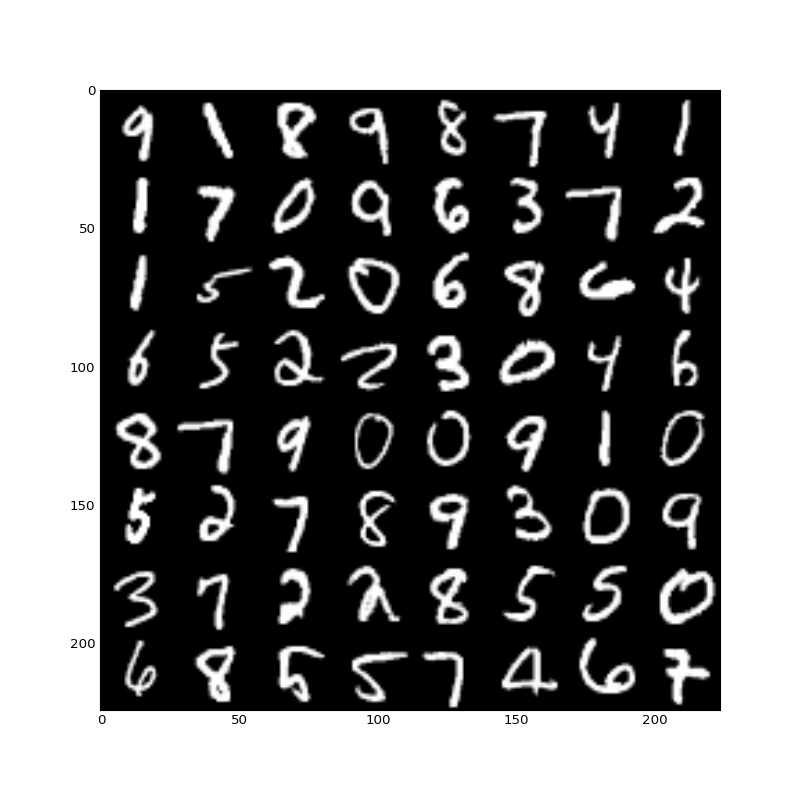

<IPython.core.display.Javascript object>


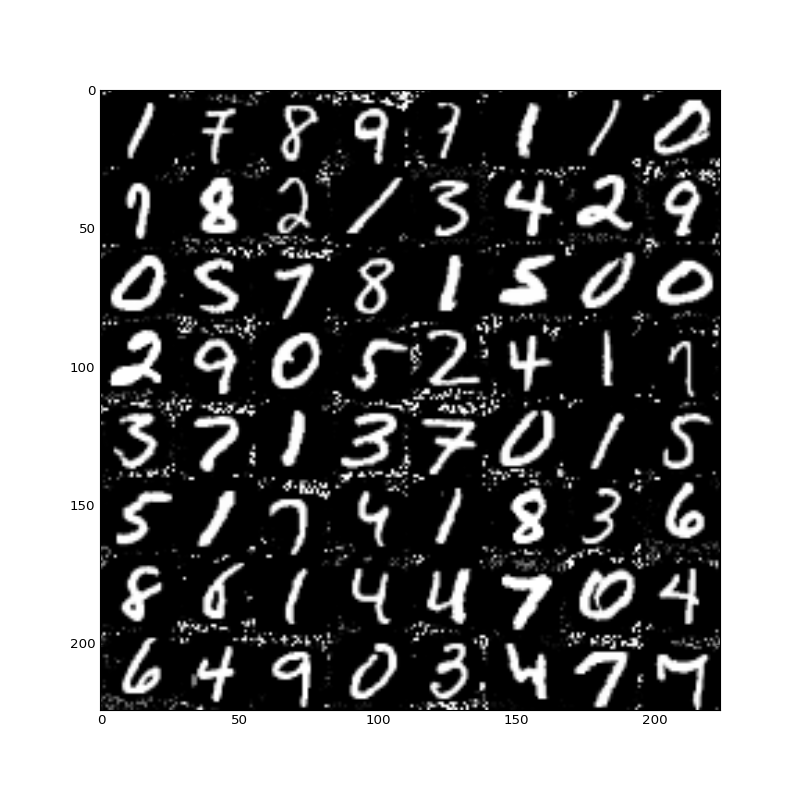

<IPython.core.display.Javascript object>


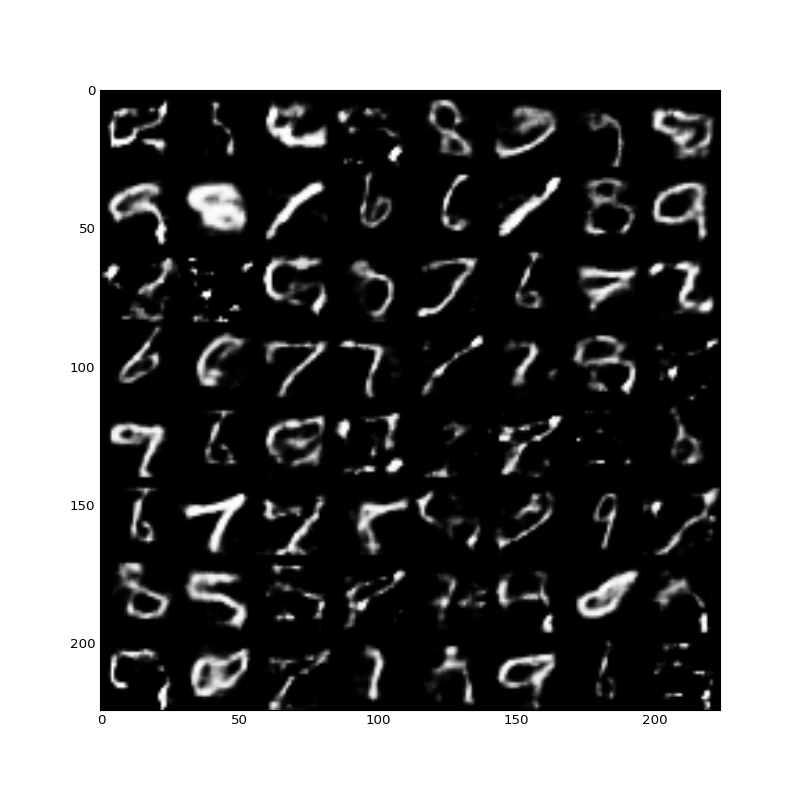

In [13]:
# Plot ood figures
def plot_ood_figures(classifier, model_name):
    inds_out = np.where(classifier.Y_test[:, classifier.number_of_classes-1] == 1)[0]
    inds_in = np.where(classifier.Y_test[:, classifier.number_of_classes-1] == 0)[0]

    X = classifier.X_test[inds_out,]
    X_in = classifier.X_test[inds_in,]

    n = 8
    digit_size = 28


    inds_0 = np.random.choice(range(int(inds_in.shape[0]/2)), n*n)
    inds_1 = np.random.choice(range(int(inds_out.shape[0]/2)), n*n)
    inds_2 = np.random.choice(range(int(inds_out.shape[0]/2), inds_out.shape[0]), n*n)

    
    X_in = X_in[inds_0]
    X_nullspace = X[inds_1]
    X_maha = X[inds_2]

    filename_0 = os.path.join(model_name, "indist_images.png")
    filename_1 = os.path.join(model_name, "nullspace_generated_ood.png")
    filename_2 = os.path.join(model_name, "mahalanobis_generated_ood.png")

    figure_0 = np.zeros((digit_size * n, digit_size * n))
    figure_1 = np.zeros((digit_size * n, digit_size * n))
    figure_2 = np.zeros((digit_size * n, digit_size * n))


    count = 0
    for i in range(n):
        for j in range(n):
            digit_0 = X_in[count].reshape(digit_size, digit_size)
            digit_1 = X_nullspace[count].reshape(digit_size, digit_size)
            digit_2 = X_maha[count].reshape(digit_size, digit_size)

            figure_0[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit_0
            figure_1[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit_1
            figure_2[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit_2

            count += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(figure_0, cmap='Greys_r')
    plt.savefig(filename_0)

    plt.figure(figsize=(10, 10))
    plt.imshow(figure_1, cmap='Greys_r')
    plt.savefig(filename_1)

    plt.figure(figsize=(10, 10))
    plt.imshow(figure_2, cmap='Greys_r')
    plt.savefig(filename_2)

    plt.show()


plot_ood_figures(classifier, model_name="vae")

In [ ]:
#import numpy as np
#from sklearn import metrics

    
inds_out = np.where(classifier.Y_test[:, number_of_classes-1] == 1)[0]
inds_in = np.array(range(classifier.Y_test.shape[0]))
inds_in = np.delete(inds_in, inds_out, axis=0)
p_out = 1.0 - classifier.model.predict(classifier.X_test[inds_out])[:,-1]
p_in = 1.0 - classifier.model.predict(classifier.X_test[inds_in])[:,-1]
#p_ood_in_dist = 1 - classifier.model.predict(classifier.X_test_ood_in_dist)[:,-1]
p_ood_out_dist = 1 - classifier.model.predict(classifier.X_test_ood_out_dist)[:,-1]
p_ood_sphere = 1 - classifier.model.predict_proba(classifier.x_ood_sphere)[:,-1]
p_ood_notMNIST = 1 - classifier.model.predict_proba(classifier.X_test_notMNIST)[:,-1]
p_ood_eMNIST = 1 - classifier.model.predict_proba(classifier.X_test_eMNIST)[:,-1]

print("SKLERAN AUROC and fpr_95 for generated_ood is: ", sklearn_auroc(p_in, p_out))
#print("SKLEARN AUROC and fpr_95 for %s_ood is: " % in_dist, sklearn_auroc(p_in, p_ood_in_dist))
print("SKLEARN AUROC and fpr_95 for %s_ood is: " % out_dist, sklearn_auroc(p_in, p_ood_out_dist))
print("SKLEARN AUROC and fpr_95 for sphere_ood is: ", sklearn_auroc(p_in, p_ood_sphere))
print("SKLEARN AUROC and fpr_95 for notMNIST is: ", sklearn_auroc(p_in, p_ood_notMNIST))
print("SKLEARN AUROC and fpr_95 for eMnist is: ", sklearn_auroc(p_in, p_ood_eMNIST))



In [ ]:
preds = classifier.model.predict(classifier.X_test_eMNIST)[:,-1]
print(np.max(preds))
print(np.min(preds))
print(np.median(preds))
print(np.mean(preds))

In [ ]:
classifier.X_test_ood_out_dist.shape

In [ ]:
preds = classifier.model.predict(classifier.X_test_ood_in_dist)
c = np.argmax(preds, axis=-1)
np.where((c==number_of_classes-1))[0].shape[0]*1.0/c.shape[0]

In [ ]:
np.sum(preds[0])

In [ ]:
np.where((preds >= (1.0/number_of_classes)))[0].shape[0]*1.0/preds.shape[0]

In [ ]:
classifier.model.evaluate(classifier.X_test_ood_in_dist, classifier.Y_test_ood_in_dist)

In [ ]:
a = np.argmax(classifier.Y_test_ood_in_dist, axis=-1)
print(a.shape)
print(np.sum(a))
print(4861*5)

In [ ]:
(_, _),(a, b) = fashion_mnist.load_data()
#b=np.array(b)
print(b.shape)

In [ ]:
b[:]=2

In [ ]:
inds_out = np.where(classifier.Y_test[:, 2] == 1)[0]
p=classifier.model.predict(classifier.X_test)
print(p)

In [ ]:
x_test_ood, y_test_ood = np.load('x_test_ood.npy'), np.load('y_test_ood.npy')
print(x_test_ood.shape)

In [ ]:
K.eval(classifier.model.optimizer.lr)

In [ ]:
inds = np.random.choice(range(2000), 1000)

In [ ]:
type(range(10)[0])

In [ ]:
print(np.max(classifier.X_train))
print(np.min(classifier.X_train))

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
vae_10d.y_train.shape

In [ ]:
ind_test = np.where((vae_7d.y_test == 0) | (vae_7d.y_test == 1))[0]

classifier.evaluate_ood((vae_7d.x_test[ind_test], np_utils.to_categorical(vae_7d.y_test[ind_test], 3)))

p_in = 1.0 - classifier.model.predict_proba(vae_7d.x_test[ind_test])[:,-1]

In [ ]:
print(np.median(p_in))

In [ ]:
p_ood_fmnist = classifier.model.predict_proba(classifier.X_test_ood_fmnist)[:,-1]

In [ ]:
print(np.median(p_ood_fmnist))

In [ ]:
x_sphere_ood, y_sphere_ood = generate_nd_sphere_data(6, 8, 2000)

In [ ]:
classifier.evaluate_ood((x_sphere_ood, y_sphere_ood))

In [ ]:
p_ood_sphere = np.max(classifier.model.predict_proba(x_sphere_ood), axis=1)

In [ ]:
np.median(p_ood_sphere)

In [ ]:
print("AUROC for fmnist_ood is: ", auroc(p_in, p_ood_fmnist))

print("AUROC for sphere_ood is: ", auroc(p_in, p_ood_sphere))

In [ ]:
# Classifier

# Build a classifier with outlier samples only from the boundary.
import keras

class Classifier_2class:

    # 3 Class classifier - class 2 represents outliers and class 0,1 represent inliers.
    # Class 0 sampled from a circle centered at (x, y) = (-2, 0) with radius 0.5
    # Class 1 sampled from a circle centered at (x, y) = (+2, 0) with radius 0.5
    # Class 2 sampled from rectagle with origin (x, y) = (-3, -1) with h=2, w=6 excluding regions covered by inliers.

    # Generate n points uniformly within a circle of radius r, centered at (x, y)
    # return as a numpy array n x 2 of dtype = float32
    def __init__(self, vae):
        self.number_of_classes = number_of_classes-1
        self.input_shape = (28, 28, 1)
        self.input_dim = 28*28
        self.epochs = 200
        self.batch_size = 128
        self.init_lr = 0.1
        self.decay = 1e-01

        self.model = self.get_model()

        self.X_train, self.Y_train, self.X_test, self.Y_test, self.X_test_ood_out_dist, self.X_test_notMNIST, self.X_test_eMNIST = self.get_data()

        self.x_ood_sphere, self.y_ood_sphere = generate_nd_sphere_data(np.ones(2000)*(self.get_sphere_radius(vae.x_train)+2), self.input_dim, 2000)
        self.x_ood_sphere = np.reshape(self.x_ood_sphere, [-1, self.input_shape[0], self.input_shape[1], self.input_shape[2]])

        # save data for gan experiment
        
        np.save('X_train_10d.npy', self.X_train)
        np.save('X_test_10d.npy', self.X_test)
        np.save('Y_train_10d.npy', self.Y_train)
        np.save('Y_test_10d.npy', self.Y_test)


        
    def get_sphere_radius(self, x):
        return np.max(np.sqrt(np.sum(np.square(x), axis=(1, 2, 3))))

    def get_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=self.input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.number_of_classes))
        model.add(Activation(tf.nn.softmax))
        model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(self.init_lr),
              metrics=['accuracy'])
        return model


    def train(self):
        # fit the model
        self.model.fit(self.X_train, self.Y_train, nb_epoch=self.epochs, 
                       validation_data=(self.X_test, self.Y_test), batch_size=self.batch_size, shuffle=True,
                      callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

        self.model.save('classifier_10d_nclass.h5')
        print("Train results")
        self.model.evaluate(self.X_train, self.Y_train)
        print("Test results")
        self.model.evaluate(self.X_test, self.Y_test)
        self.calculate_auroc()
        # self.evaluate_ood((self.X_test_ood_fmnist, self.Y_test_ood_fmnist))



    def evaluate_ood(self, data):
        x, y = data
        print(self.model.evaluate(x, y))



    def calculate_auroc(self):

        p_in = np.max(self.model.predict(self.X_test), axis=1)
        p_ood_out_dist = np.max(self.model.predict(self.X_test_ood_out_dist), axis=1)
        p_ood_sphere = np.max(self.model.predict_proba(self.x_ood_sphere), axis=1)
        p_ood_notMNIST = np.max(self.model.predict_proba(self.X_test_notMNIST), axis=1)
        p_ood_eMNIST = np.max(self.model.predict_proba(self.X_test_eMNIST), axis=1)

        print("SKLEARN AUROC and fpr_95 for %s_ood is: " % out_dist, sklearn_auroc(p_in, p_ood_out_dist))
        print("SKLEARN AUROC and fpr_95 for sphere_ood is: ", sklearn_auroc(p_in, p_ood_sphere))
        print("SKLEARN AUROC and fpr_95 for notMNIST is: ", sklearn_auroc(p_in, p_ood_notMNIST))
        print("SKLEARN AUROC and fpr_95 for eMnist is: ", sklearn_auroc(p_in, p_ood_eMNIST))



    def get_jacobian_functions(self, model, classes=None):

        if model==None:
            print("The model is none.")
            return None
    
        if classes==None:
            classes=range(model.output.shape[-1])
        #--------------------------------    
        gradients = {}
        for c in classes:
            grads = K.gradients(model.output[:,c], model.layers[0].input)[0]
            gradients[c]= K.function([model.layers[0].input], [grads])              
        #--------------------------------
        return gradients

    # output is np.array of shape (inputs.shape[0], input_dim, latent_dim)
    def get_jacobian(self, model, inputs):
        J_fn = self.get_jacobian_functions(model)

        J = np.empty((inputs.shape[0], model.output.shape[-1], model.input.shape[-1]))

        for i in range(len(J_fn)):
            J[:, i, :] = J_fn[i]([inputs])[0]

        return J

    # Calculate null-space for all training points
    def get_nullspace(self, data, encoder, decoder):
        z_mean, _, _ = encoder.predict(data)
        J = self.get_jacobian(decoder, z_mean)

        N_dims = (J.shape[1]-J.shape[2], J.shape[1])
        N = np.empty((data.shape[0], N_dims[0], N_dims[1]))

        for i in range(J.shape[0]):
            A = Matrix(np.transpose(J[i]))
            n = np.array(A.nullspace()).astype(np.float32)

            # make unit-vectors
            N[i] = n*1.0/np.sqrt(np.sum(np.square(n), axis=-1)[:, None])

        return N

    def generate_ood_points(self, data, encoder, decoder, N=None):
        epsilon = 1
        rand_nums = np.random.choice([-1, 1], data.shape[0])
        if not N:
            ood_data = []
            for i in range(data.shape[0]):
                N = self.get_nullspace(data[i], encoder, decoder)
                ood_data.append(data[i] + rand_nums[i] * epsilon * N)
        else:
            ood_data = []
            for i in range(data.shape[0]):
                ood_data.append(data[i] + rand_nums[i] * epsilon * N[i])

        return np.squeeze(np.array(ood_data)), 2 * np.ones((data.shape[0], 1))

        

    def get_data(self):

        # take digits 0 and 1 as inliers and rest as outliers

        ind_train = np.where((vae.y_train >= in_class_min) & (vae.y_train <= in_class_max))[0]
        ind_test = np.where((vae.y_test >= in_class_min) & (vae.y_test <= in_class_max))[0]

        # For fmnist as ood
        (_, _),(x_test_ood_out_dist, y_test_ood_out_dist) = out_dist_dataset.load_data()
        image_size = x_test_ood_out_dist.shape[1]
        x_test_ood_out_dist = np.reshape(x_test_ood_out_dist, [-1, image_size, image_size, 1])

        x_test_ood_out_dist = x_test_ood_out_dist.astype('float32')/255.

        X_train = vae.x_train[ind_train,]
        X_test = vae.x_test[ind_test,]

        Y_train = np.expand_dims(vae.y_train[ind_train,], axis=1)
        Y_test = np.expand_dims(vae.y_test[ind_test,], axis=1)

        Y_train = np_utils.to_categorical(Y_train, self.number_of_classes)
        Y_test = np_utils.to_categorical(Y_test, self.number_of_classes)


        print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

        x_test_notMNIST = np.load('/data/sverneka/dataset/notMNIST.npy').astype('float32')/255.

        # EMNIST LETTERS TEST
        x_test_eMNIST = np.array(pd.read_csv("/data/sverneka/dataset/emnist-letters-test.csv", index_col=None, header=None))[:, 1:].astype('float32')/255.0
        x_test_eMNIST = x_test_eMNIST.reshape(x_test_eMNIST.shape[0], 28, 28, 1)

        return X_train, Y_train, X_test, Y_test, x_test_ood_out_dist, x_test_notMNIST, x_test_eMNIST



In [ ]:
classifier_2class = Classifier_2class(vae)

classifier_2class.train()

In [ ]:
p_ood_fmnist = np.max(classifier_2class.model.predict_proba(classifier_2class.X_test_ood_fmnist), axis=1)
p_in = np.max(classifier_2class.model.predict_proba(classifier_2class.X_test), axis=1)

In [ ]:
print(auroc(p_in, p_ood_fmnist))

In [ ]:
print(np.median(p))

In [ ]:
s = np.where(p >= 0.99)[0].shape[0]
print(s*1.0/p.shape[0])